## knee-method for optional stopping

In [49]:
from asreview import open_state
from asreview import ASReviewProject
from asreview import ASReviewData
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## load asreview output file at the beginning of the oracle mode

This file gives us the initial ranking of the papers

In [2]:
with open_state("bib/round1/pubmed-9NOTanimal-set 2-ready-for-ASReview.asreview") as state:
    last_ranking = state.get_last_ranking()
    last_probabilities = state.get_last_probabilities()
print("RANKING:")
print(last_ranking[["record_id", "ranking"]])
print("RELEVANCE SCORES:")
print(last_probabilities)

RANKING:
      record_id  ranking
0          5540        0
1           993        1
2          5186        2
3          1566        3
4          3179        4
...         ...      ...
6654       2234     6654
6655       2624     6655
6656        565     6656
6657       5748     6657
6658       2480     6658

[6659 rows x 2 columns]
RELEVANCE SCORES:
0       0.724825
1       0.725298
2       0.720239
3       0.717560
4       0.714143
          ...   
6654    0.729520
6655    0.718747
6656    0.716503
6657    0.718573
6658    0.719486
Name: proba, Length: 6659, dtype: float64


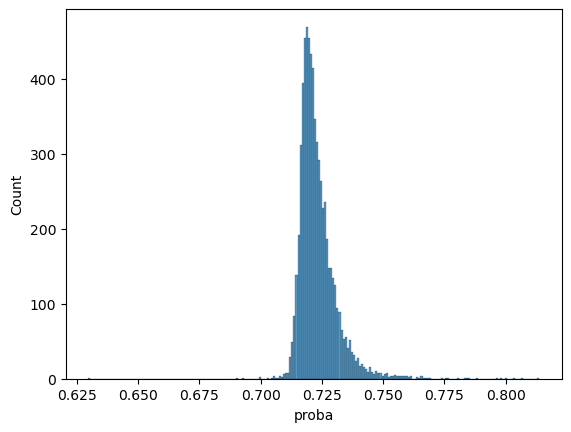

In [3]:
# plot of the latest probabilities
sns.histplot(last_probabilities)
plt.show()

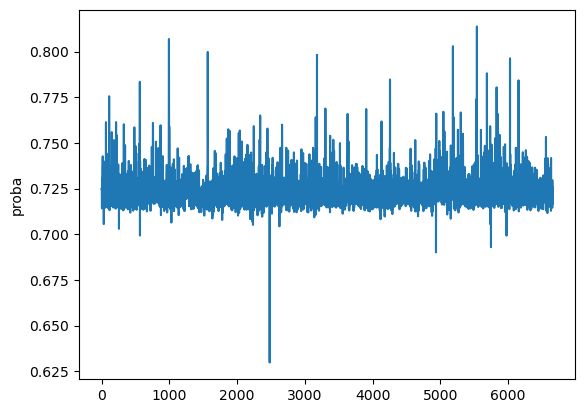

In [4]:
# plot of the the probabilities ranked 
sns.lineplot(last_probabilities)
plt.show()

### get the first 50 papers

In [5]:
project_path = Path("bib/round1/tmp_data")
project_path.mkdir()
project = ASReviewProject.load("bib/round1/pubmed-9NOTanimal-set 2-ready-for-ASReview.asreview", project_path)


In [13]:
dataset_fp = Path(
    project_path, project.config["id"], "data", project.config["dataset_path"]
)
dataset = ASReviewData.from_file(dataset_fp)
print(f"The dataset contains {len(dataset)} records.")
records = dataset.to_dataframe().reset_index()

The dataset contains 6659 records.


In [22]:
len(last_ranking[["record_id", "ranking"]])

6659

In [23]:
temp = pd.merge(records, last_ranking[["record_id", "ranking"]], how='left', on='record_id')

In [24]:
len(temp)

6659

In [37]:
ranking_sorted = temp.sort_values(by='ranking', ascending=True)

In [38]:
duplicated_columns = ranking_sorted.columns.str.endswith('.1')

In [39]:
ranking_sorted_dedup = ranking_sorted.loc[:, ~duplicated_columns]

In [51]:
ranking_sorted_dedup.head()

,record_id,Unnamed: 0,title,authors,type_of_reference,abstract,language,keywords,doi,ranking,relevant
5540,5540,5540,Temperature-dependent transmission of rotaviru...,"[""{'author': 'Atchison, C J', 'author_abbrevia...",JOUR,"In Europe, rotavirus gastroenteritis peaks in ...",eng,,10.1098/rspb.2009.1755,0,NaN
993,993,993,Climate variability and campylobacter infectio...,"[""{'author': 'Kovats, R Sari', 'author_abbrevi...",JOUR,Campylobacter is among the most important agen...,eng,,10.1007/s00484-004-0241-3,1,NaN
5186,5186,5186,Seasonality and the effects of weather on Camp...,"[""{'author': 'Djennad, Abdelmajid', 'author_ab...",JOUR,BACKGROUND: Campylobacteriosis is a major publ...,eng,"['Campylobacter', 'Climate change', 'Environme...",10.1186/s12879-019-3840-7,2,NaN
1566,1566,1566,Determinants of Rotavirus Transmission: A Lag ...,"[""{'author': 'van Gaalen, Rolina D', 'author_a...",JOUR,Rotavirus is a common viral infection among yo...,eng,,10.1097/EDE.0000000000000654,3,NaN
3179,3179,3179,Influence of weather and climate on cryptospor...,"[""{'author': 'Ikiroma, Isotein Adalia', 'autho...",JOUR,Studies have shown that climatic factors can s...,eng,"['climate', 'cryptosporidiosis', 'public healt...",10.1111/zph.12785,4,NaN


In [50]:
ranking_sorted_dedup.loc[:, 'relevant'] = np.nan


In [52]:
ranking_sorted_dedup.to_csv('bib/round1/predictions-round1.csv', index=False)

### Load recall file

In [32]:
df = pd.read_csv('ASReviewLABprogressRecall.csv')
df = df.rename(columns={"category": "category", "Relevant records": "Relevant by ASReview LAB"})

In [33]:
df.head()

,category,Relevant by ASReview LAB,Random relevant
0,1,1,0
1,2,2,0
2,3,3,0
3,4,4,0
4,5,4,0


In [36]:
print(f' We reviewed {df.shape[0]} papers so far')

 We reviewed 117 papers so far


This function aims to determine stopping criteria based on slopes of relevance scores in a DataFrame. It calculates a knee point where the relevance slope changes significantly.

- k: Minimum number of relevant items to consider stopping.
- 'rho': Threshold ratio to determine if the knee point is found.
- 'df': DataFrame containing two columns: 'category' and 'Relevant by ASReview LAB' / Recall plot

Algorithm found in: https://github.com/MaxvanHaastrecht/ASReview-Knee-Method/blob/main/Cormack%20Grossman%20Knee%20Algorithm.ipynb

Slightly changed to get a plot and some informative prints / comments to understand what's going on

In [7]:
def calculate_knee_values(k, rho, df, plot=True):
    """
    Calculate knee values where the relevance slope changes significantly.

    Parameters:
    k (int): Minimum number of relevant items to consider stopping.
    rho (float): Threshold ratio to determine if the knee point is found.
    df (pd.DataFrame): DataFrame containing 'category' and 'Relevant by ASReview LAB' columns.

    Returns:
    tuple: (stop_i, stop_s, stop_relevant, slope_stop) if stopping criterion is found,
           otherwise (-1, -1, -1, -1).
    """

    # Variables to store stopping values
    stop_i = -1
    stop_s = -1
    stop_relevant = -1
    slope_stop = -1
    
    inflection_found = False

    
    for rank_s, relevant in zip(df['category'], df['Relevant by ASReview LAB']):
        
        # If knee found, break
        if stop_s > 0:
            inflection_found = True
            print('stopping criterion found')
            break
        
        # If number relevant less than k, do not even need to consider stopping
        if relevant < k:
            continue
        
        # Index (start=0) is one lower than rank (start=1)
        index_s = rank_s - 1
        
        # Loop over all i and compare slopes
        for rank_i in range(1, rank_s):
            
            # Calculate slope until i
            index_i = rank_i - 1
            num_relevant_i = df['Relevant by ASReview LAB'][index_i]
            
            slope_i = num_relevant_i / rank_i
            
            # If slope until i is zero, cannot exceed cutoff
            if slope_i == 0:
                continue
            
            num_relevant_s = df['Relevant by ASReview LAB'][index_s]
            
            # Calculate slope of s
            # Add 1 to numerator to avoid edge cases with i very close to s
            slope_s = (1 + num_relevant_s - num_relevant_i) / (rank_s - rank_i)
            
            # Calculate slope ratio
            slope_ratio = slope_i / slope_s
            
            # Check if slope_ratio greater than cutoff
            if slope_ratio > rho:
                stop_i = rank_i
                stop_s = rank_s
                stop_relevant = num_relevant_s
                slope_stop = slope_ratio
                inflection_found = True
                break
                
    if not inflection_found:
        print('No stopping criterion found')
        
    # plot the data
    if plot:
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=df, x='category', y='Relevant by ASReview LAB', 
                     color='k', label='Relevant by ASReview LAB',
                    marker='o')

        if inflection_found:
            plt.axvline(x=stop_s, color='r', linestyle='--', label=f'Inflection Point at rank {stop_s}')

        plt.xlabel('paper number')
        plt.ylabel('Relevant by ASReview LAB')
        plt.legend()
        plt.grid(True)
        plt.show()
                
    return stop_i, stop_s, stop_relevant, slope_stop

No stopping criterion found


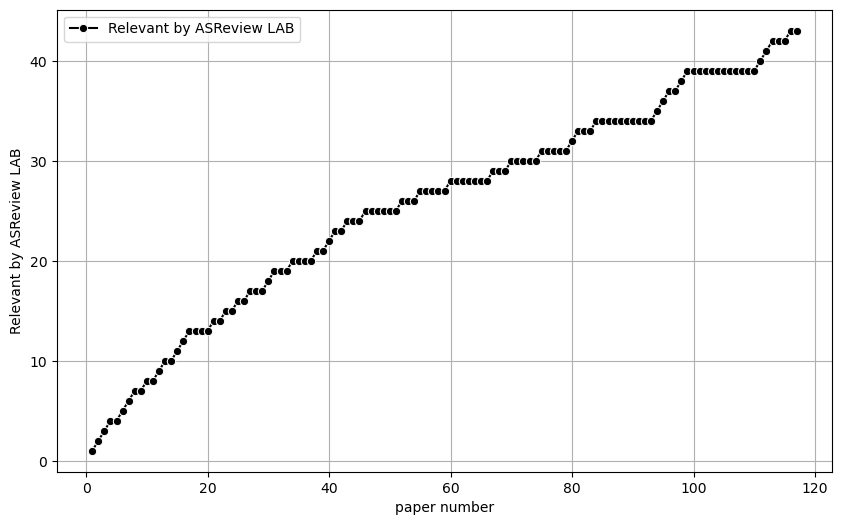

In [8]:
k = 10
rho = 6

# 70% 
i, s, num_relevant, slope_ratio = calculate_knee_values(k, rho, df)

In [9]:
print('We stop at s=' + str(s) + ' since the slope from 0 to i='
      + str(i) + ' is ' + str(round(slope_ratio, 2)) + ' times higher '
     + 'than the intermediate slope between i and s.')

We stop at s=-1 since the slope from 0 to i=-1 is -1 times higher than the intermediate slope between i and s.


In [10]:
R = df['Random relevant'].iat[-1] # number of relevant documents, generally unknown

In [18]:
print('At the stopping point we have found ' + str(num_relevant)
     + ' relevant papers. This corresponds to a recall of '
     + str(round(num_relevant/R, 2)*100) + '%.')

At the stopping point we have found -1 relevant papers. This corresponds to a recall of -50.0%.


In [19]:
# We can simulate how the stopping criteria changes based on parameters of k and rho
import numpy as np
from tqdm.notebook import tqdm

k = 10

# WARNING: setting 'num' high (e.g., >500) will cause code to take very long
rho_values = np.linspace(3, 10, num = 10)

s_values = []
num_rel_values = []

for rho_value in tqdm(rho_values):
    
    i, s, n, r = calculate_knee_values(k, rho_value, df, plot=False)
    
    s_values.append(s)
    num_rel_values.append(n)

  0%|          | 0/10 [00:00<?, ?it/s]

stopping criterion found
stopping criterion found
No stopping criterion found
No stopping criterion found
No stopping criterion found
No stopping criterion found
No stopping criterion found
No stopping criterion found
No stopping criterion found
No stopping criterion found


In [20]:
num_rel_values

[34, 39, -1, -1, -1, -1, -1, -1, -1, -1]

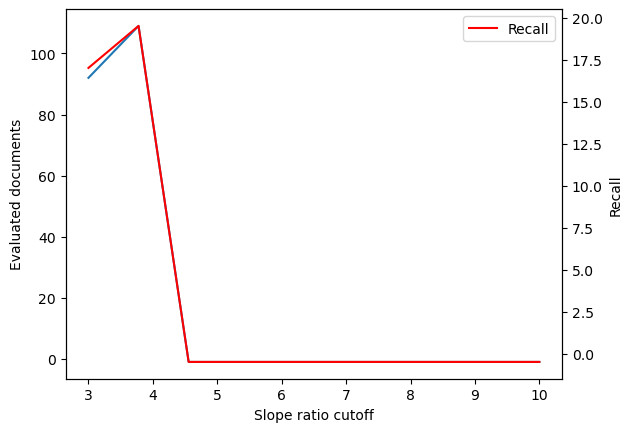

In [37]:
# plot the results of the simulation above
ax = sns.lineplot(x = rho_values, y = s_values)
ax2 = plt.twinx()
sns.lineplot(x = rho_values, y = num_rel_values/R, label = 'Recall', color='r', ax=ax2)

ax.set(xlabel='Slope ratio cutoff', ylabel='Evaluated documents')
ax2.set(ylabel='Recall')

plt.show()

In [ ]:
cd 